In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from tqdm import tqdm
import dill
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as mlines
from matplotlib.patches import FancyArrowPatch
import seaborn as sns
import torch
from torch.distributions import MultivariateNormal
from sbi.inference import FMPE, SNPE, NPSE
from sbi.analysis import pairplot
from sbi.utils import BoxUniform
import sbibm
from lf2i.inference import LF2I
from lf2i.test_statistics.posterior import Posterior
from lf2i.test_statistics.waldo import Waldo
from lf2i.calibration.critical_values import train_qr_algorithm
from lf2i.utils.other_methods import hpd_region
from lf2i.plot.parameter_regions import plot_parameter_regions
from lf2i.plot.coverage_diagnostics import coverage_probability_plot
from lf2i.plot.power_diagnostics import set_size_plot
from tsi.temp.utils import kdeplots2D

/home/jcarzon/miniconda3/envs/tsi_update/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
plt.rc('text', usetex=True)  # Enable LaTeX
plt.rc('font', family='serif')  # Use a serif font (e.g., Computer Modern)
plt.rcParams['text.latex.preamble'] = r'''
    \usepackage{amsmath}  % For \mathbb
    \usepackage{amssymb}  % For \mathbb
    \usepackage{bm}       % For bold math symbols
    \usepackage{underscore} % If underscores are needed
'''

In [4]:
### Settings
POI_DIM = 2  # parameter of interest
PRIOR_LOC = [0, 0]
PRIOR_VAR = 2.0 # (6*np.sqrt(2.0))**2
POI_BOUNDS = {r'$\theta_1$': (-10, 10), r'$\theta_2$': (-10, 10)}
PRIOR = MultivariateNormal(
    loc=torch.Tensor(PRIOR_LOC), covariance_matrix=PRIOR_VAR*torch.eye(n=POI_DIM)
)

B = 50_000  # num simulations to estimate posterior and test statistics
B_PRIME = 30_000  # num simulations to estimate critical values
B_DOUBLE_PRIME = 10_000  # num simulations to do diagnostics
EVAL_GRID_SIZE = 25_000  # num evaluation points over parameter space to construct confidence sets
CONFIDENCE_LEVEL = 0.954, 0.683  # 0.99

REFERENCE = MultivariateNormal(
    loc=torch.Tensor(PRIOR_LOC), covariance_matrix=25*torch.eye(n=POI_DIM)
)
REFERENCE_DIAGNOSTICS = BoxUniform(
    low=torch.tensor((POI_BOUNDS[r'$\theta_1$'][0]-1, POI_BOUNDS[r'$\theta_2$'][0]-1)),
    high=torch.tensor((POI_BOUNDS[r'$\theta_1$'][1]+1, POI_BOUNDS[r'$\theta_2$'][1]+1))
)
# REFERENCE = PRIOR
EVAL_GRID_DISTR = BoxUniform(
    low=torch.tensor((POI_BOUNDS[r'$\theta_1$'][0], POI_BOUNDS[r'$\theta_2$'][0])),
    high=torch.tensor((POI_BOUNDS[r'$\theta_1$'][1], POI_BOUNDS[r'$\theta_2$'][1]))
)

POSTERIOR_KWARGS = {
    # 'norm_posterior': None
}
DEVICE = 'cpu'
task = sbibm.get_task('gaussian_mixture')
simulator = task.get_simulator()
SIM_PARAMS = {
    "mixture_locs_factor": [0.75, 0.75],
    "mixture_scales": [1.0, 0.1],
    "mixture_weights": [0.5, 0.5],
}
train_simulator = lambda theta: gaussian_mixture(theta, mixture_locs_factor=SIM_PARAMS['mixture_locs_factor'])

# Strong prior

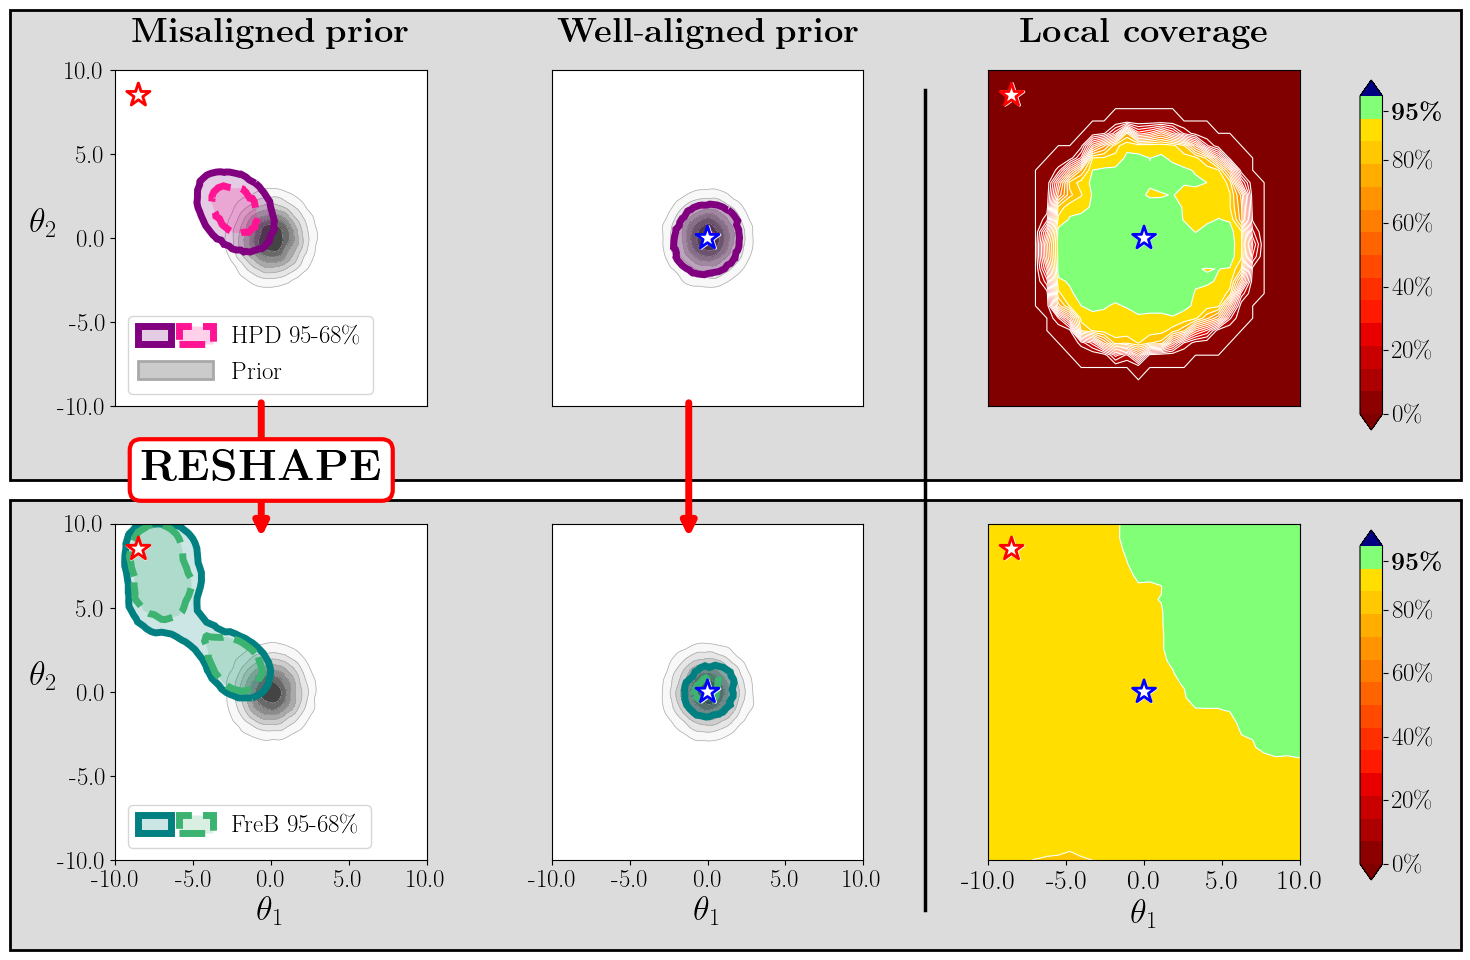

In [33]:
# experiment_dir = 'results/snpe/uniform_prior'
main_dir = f'results/concept_shift/gaussian_reference/posterior_fmpe/p_values_mnn'
experiment_dir = f'results/concept_shift/gaussian_reference/posterior_fmpe/p_values_mnn/20251114_163627_lr0.0005_bs32_ep150_wd1e-05_gp0.0_dr0.0_2b7dfa41'

with open(f'{experiment_dir}/obs_x_theta.pkl', 'rb') as f:
    examples = dill.load(f)
    true_theta = examples['true_theta']
    obs_x = examples['obs_x']
with open(f'{experiment_dir}/lf2i_strong_prior.pkl', 'rb') as f:
    lf2i = dill.load(f)
with open(f'{experiment_dir}/confidence_sets_strong_prior.pkl', 'rb') as f:
    confidence_sets = dill.load(f)
with open(f'{main_dir}/credible_sets_strong_prior.pkl', 'rb') as f:
    credible_sets = dill.load(f)
with open(f'{experiment_dir}/diagn_confset_strong_prior.pkl', 'rb') as f:
    diagn_objects = dill.load(f)
with open(f'{main_dir}/diagn_cred_strong_prior.pkl', 'rb') as f:
    diagn_objects_cred = dill.load(f)

idx_1 = 1
idx_2 = -1

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.gridspec import GridSpec
import numpy as np

fig = plt.figure(figsize=(15, 10))
gs = GridSpec(2, 3, figure=fig, left=0.09, top=0.91, bottom=0.12, right=0.88, hspace=0.35, wspace=0.4)

# Create axes from gridspec
axs = [[fig.add_subplot(gs[i, j]) for j in range(3)] for i in range(2)]

# Add gainsboro patches behind each row (non-overlapping)
# Top row patch
fig.patches.append(patches.Rectangle(
    (0.02, 0.5), 0.967, 0.47, 
    transform=fig.transFigure, 
    edgecolor='black', 
    linewidth=2, 
    facecolor="gainsboro", 
    zorder=-1
))

# Bottom row patch
fig.patches.append(patches.Rectangle(
    (0.02, 0.03), 0.967, 0.45, 
    transform=fig.transFigure, 
    edgecolor='black', 
    linewidth=2, 
    facecolor="gainsboro", 
    zorder=-1
))

idx_obs = idx_1
plot_parameter_regions(
    *[credible_sets[idx_obs][j] for j in range(len(CONFIDENCE_LEVEL))],
    param_dim=2,
    # true_parameter=params_for_size[idx_obs, :],
    true_parameter = true_theta[idx_obs, :],
    prior_samples=PRIOR.sample(sample_shape=(50_000, )).numpy(),
    parameter_space_bounds={
        r'$\theta_1$': dict(zip(['low', 'high'], POI_BOUNDS[r'$\theta_1$'])), 
        r'$\theta_2$': dict(zip(['low', 'high'], POI_BOUNDS[r'$\theta_2$'])), 
    },
    colors=[
        'purple', 'deeppink',
    ],
    region_names=[
        *[f'HPD {int(cl*100):.0f}\%' for cl in CONFIDENCE_LEVEL],
    ],
    labels=[r'$\theta_1$', r'$\theta_2$'],
    linestyles=['-', '--'],
    param_names=[r'$\theta_1$', r'$\theta_2$'],
    alpha_shape=True,
    alpha=3,
    scatter=False,
    remove_legend=False,
    title=r'$\mathbf{Misaligned\ prior}$',
    custom_ax=axs[0][0]
)

plot_parameter_regions(
    *[confidence_sets[j][idx_obs] for j in range(len(CONFIDENCE_LEVEL))],
    param_dim=2,
    # true_parameter=params_for_size[idx_obs, :],
    true_parameter = true_theta[idx_obs, :],
    prior_samples=PRIOR.sample(sample_shape=(50_000, )).numpy(),
    parameter_space_bounds={
        r'$\theta_1$': dict(zip(['low', 'high'], POI_BOUNDS[r'$\theta_1$'])), 
        r'$\theta_2$': dict(zip(['low', 'high'], POI_BOUNDS[r'$\theta_2$'])), 
    },
    colors=[
        'teal', 'mediumseagreen',
    ],
    region_names=[
        *[f'FreB {int(cl*100):.0f}\%' for cl in CONFIDENCE_LEVEL],
    ],
    labels=[r'$\theta_1$', r'$\theta_2$'],
    linestyles=['-', '--'],
    param_names=[r'$\theta_1$', r'$\theta_2$'],
    alpha_shape=True,
    alpha=1,
    scatter=False,
    remove_legend=False,
    title=None,
    custom_ax=axs[1][0]
)

idx_obs = idx_2
# true_parameter=params_for_size[idx_obs, :]
true_parameter = true_theta[idx_obs, :]
plot_parameter_regions(
    *[credible_sets[idx_obs][j] for j in range(len(CONFIDENCE_LEVEL))],
    param_dim=2,
    prior_samples=PRIOR.sample(sample_shape=(50_000, )).numpy(),
    parameter_space_bounds={
        r'$\theta_1$': dict(zip(['low', 'high'], POI_BOUNDS[r'$\theta_1$'])), 
        r'$\theta_2$': dict(zip(['low', 'high'], POI_BOUNDS[r'$\theta_2$'])), 
    },
    colors=[
        'purple', 'deeppink',
    ],
    region_names=[
        *[f'FreB {int(cl*100):.0f}\%' for cl in CONFIDENCE_LEVEL],
    ],
    labels=[r'$\theta_1$', r'$\theta_2$'],
    linestyles=['-', '--'],
    param_names=[r'$\theta_1$', r'$\theta_2$'],
    alpha_shape=True,
    alpha=3,
    scatter=False,
    remove_legend=True,
    title=r'$\mathbf{Well\text{-}aligned\ prior}$',
    custom_ax=axs[0][1]
)
axs[0][1].scatter(x=true_parameter.reshape(-1,)[0], y=true_parameter.reshape(-1,)[1],
    alpha=1, marker='*', facecolor='white', edgecolor='white', s=300, linewidth=2, zorder=10)
axs[0][1].scatter(x=true_parameter.reshape(-1,)[0], y=true_parameter.reshape(-1,)[1],
    alpha=1, marker='*', facecolor='none', edgecolor='blue', s=300, linewidth=2, zorder=10)

plot_parameter_regions(
    *[confidence_sets[j][idx_obs] for j in range(len(CONFIDENCE_LEVEL))],
    param_dim=2,
    prior_samples=PRIOR.sample(sample_shape=(50_000, )).numpy(),
    parameter_space_bounds={
        r'$\theta_1$': dict(zip(['low', 'high'], POI_BOUNDS[r'$\theta_1$'])), 
        r'$\theta_2$': dict(zip(['low', 'high'], POI_BOUNDS[r'$\theta_2$'])), 
    },
    colors=[
        'teal', 'mediumseagreen',
    ],
    region_names=[
        *[f'FreB {int(cl*100):.0f}\%' for cl in CONFIDENCE_LEVEL],
    ],
    labels=[r'$\theta_1$', r'$\theta_2$'],
    linestyles=['-', '--'],
    param_names=[r'$\theta_1$', r'$\theta_2$'],
    alpha_shape=True,
    alpha=3,
    scatter=False,
    # alpha_shape=False,
    # alpha=6,
    # scatter=True,
    remove_legend=True,
    title=None,
    custom_ax=axs[1][1]
)
axs[1][1].scatter(x=true_parameter.reshape(-1,)[0], y=true_parameter.reshape(-1,)[1],
    alpha=1, marker='*', facecolor='white', edgecolor='white', s=300, linewidth=2, zorder=10)
axs[1][1].scatter(x=true_parameter.reshape(-1,)[0], y=true_parameter.reshape(-1,)[1],
    alpha=1, marker='*', facecolor='none', edgecolor='blue', s=300, linewidth=2, zorder=10)

## Local diagnostics
hpd_diagn_plot = coverage_probability_plot(
    parameters=diagn_objects_cred[CONFIDENCE_LEVEL[0]][1],
    coverage_probability=diagn_objects_cred[CONFIDENCE_LEVEL[0]][2],
    confidence_level=CONFIDENCE_LEVEL[0],
    param_dim=2,
    vmin_vmax=(0, 100),
    xlims=(-10, 10),
    ylims=(-10, 10),
    params_labels=(r'$\theta_1$', r'$\theta_2$'),
    #figsize=(9, 7),
    title=r'\textbf{Local coverage}',
    show_text=False,
    custom_ax=axs[0][2],
    # n_bins=8,
    # n_levels=10,
)

idx_obs = idx_1
# true_parameter=params_for_size[idx_obs, :]
true_parameter = true_theta[idx_obs, :]
axs[0][2].scatter(x=true_parameter.reshape(-1,)[0], y=true_parameter.reshape(-1,)[1],
    alpha=1, marker='*', facecolor='white', edgecolor='white', s=300, linewidth=2, zorder=10)
axs[0][2].scatter(x=true_parameter.reshape(-1,)[0], y=true_parameter.reshape(-1,)[1],
    alpha=1, marker='*', facecolor='none', edgecolor='red', s=300, linewidth=2, zorder=10)

idx_obs = idx_2
# true_parameter=params_for_size[idx_obs, :]
true_parameter = true_theta[idx_obs, :]
axs[0][2].scatter(x=true_parameter.reshape(-1,)[0], y=true_parameter.reshape(-1,)[1],
    alpha=1, marker='*', facecolor='white', edgecolor='white', s=300, linewidth=2, zorder=10)
axs[0][2].scatter(x=true_parameter.reshape(-1,)[0], y=true_parameter.reshape(-1,)[1],
    alpha=1, marker='*', facecolor='none', edgecolor='blue', s=300, linewidth=2, zorder=10)

freb_diagn_plot = coverage_probability_plot(
    parameters=diagn_objects[CONFIDENCE_LEVEL[0]][1],
    coverage_probability=diagn_objects[CONFIDENCE_LEVEL[0]][2],
    confidence_level=CONFIDENCE_LEVEL[0],
    param_dim=2,
    vmin_vmax=(0, 100),
    params_labels=(r'$\theta_1$', r'$\theta_2$'),
    xlims=(-10, 10),
    ylims=(-10, 10),
    #figsize=(9, 7),
    title=None,
    show_text=False,
    custom_ax=axs[1][2],
    # n_bins=8,
    # n_levels=10
)

idx_obs = idx_1
# true_parameter=params_for_size[idx_obs, :]
true_parameter = true_theta[idx_obs, :]
axs[1][2].scatter(x=true_parameter.reshape(-1,)[0], y=true_parameter.reshape(-1,)[1],
    alpha=1, marker='*', facecolor='white', edgecolor='white', s=300, linewidth=2, zorder=10)
axs[1][2].scatter(x=true_parameter.reshape(-1,)[0], y=true_parameter.reshape(-1,)[1],
    alpha=1, marker='*', facecolor='none', edgecolor='red', s=300, linewidth=2, zorder=10)

idx_obs = idx_2
# true_parameter=params_for_size[idx_obs, :]
true_parameter = true_theta[idx_obs, :]
axs[1][2].scatter(x=true_parameter.reshape(-1,)[0], y=true_parameter.reshape(-1,)[1],
    alpha=1, marker='*', facecolor='white', edgecolor='white', s=300, linewidth=2, zorder=10)
axs[1][2].scatter(x=true_parameter.reshape(-1,)[0], y=true_parameter.reshape(-1,)[1],
    alpha=1, marker='*', facecolor='none', edgecolor='blue', s=300, linewidth=2, zorder=10)

#  Add colorbar for top row (rightmost column)
cax_top = fig.add_axes([0.92, 0.55, 0.015, 0.35])
cbar_top = fig.colorbar(hpd_diagn_plot, cax=cax_top)
standard_ticks = np.round(np.linspace(0, 100, num=6), 1)
all_ticks = np.unique(np.sort(np.append(standard_ticks[:-1], CONFIDENCE_LEVEL[0] * 100)))
tick_labels = [f"{label:.0f}\%" for label in all_ticks]
for i, label in enumerate(all_ticks):
    if abs(label - CONFIDENCE_LEVEL[0]*100) <= 1e-6:
        tick_labels[i] = r"$\mathbf{{{label}}}$\textbf{{\%}}".format(label=int(label))
cbar_top.ax.yaxis.set_ticks(all_ticks)
cbar_top.ax.set_yticklabels(tick_labels, fontsize=18)
cbar_top.ax.yaxis.set_ticks_position('right')
cbar_top.ax.yaxis.set_label_position('right')
# cbar_top.set_label('Percentage of $\\text{Vol}(\Theta)$', rotation=270, labelpad=20, fontsize=18)

# Add colorbar for bottom row (rightmost column)
cax_bottom = fig.add_axes([0.92, 0.10, 0.015, 0.35])
cbar_bottom = fig.colorbar(freb_diagn_plot, cax=cax_bottom)
cbar_bottom.ax.yaxis.set_ticks(all_ticks)
cbar_bottom.ax.set_yticklabels(tick_labels, fontsize=18)
cbar_bottom.ax.yaxis.set_ticks_position('right')
cbar_bottom.ax.yaxis.set_label_position('right')
# cbar_bottom.set_label('Percentage of $\\text{Vol}(\Theta)$', rotation=270, labelpad=20, fontsize=18)

line = mlines.Line2D(
    [0.63, 0.63],   # x-coords (start, end)
    [0.07, 0.89],               # y-coords (start, end)
    transform=fig.transFigure,
    ls='-',                  # dashed
    lw=2.5,
    color='black',
    clip_on=False
)

fig.add_artist(line)

fig.add_artist(FancyArrowPatch(
    posA=(0.1875, 0.58), posB=(0.1875, 0.44),
    connectionstyle="arc3,rad=0", arrowstyle='-|>', mutation_scale=20, 
    color='red', linewidth=5, zorder=10
))
fig.text(0.1875, 0.51, r"{\bf RESHAPE}", fontsize=32, color='black', ha='center', va='center', bbox=dict(facecolor='white', edgecolor='red', boxstyle='round,pad=0.25', linewidth=3), zorder=21)

fig.add_artist(FancyArrowPatch(
    posA=(0.4725, 0.58), posB=(0.4725, 0.44),
    connectionstyle="arc3,rad=0", arrowstyle='-|>', mutation_scale=20, 
    color='red', linewidth=5, zorder=10
))

axs[0][0].set_xlabel('')
axs[0][0].set_xticks([])

axs[0][1].set_xlabel('')
axs[0][1].set_xticks([])
axs[0][1].set_ylabel('')
axs[0][1].set_yticks([])

axs[0][2].set_xlabel('')
axs[0][2].set_xticks([])
axs[0][2].set_ylabel('')
axs[0][2].set_yticks([])

axs[1][1].set_ylabel('')
axs[1][1].set_yticks([])

axs[1][2].set_ylabel('')
axs[1][2].set_yticks([])

plt.savefig(f'{experiment_dir}/gmm_misspecified.png', dpi=100)
plt.savefig(f'{experiment_dir}/gmm_misspecified.pdf', dpi=100)
plt.show()

/home/jcarzon/research/tsi/lf2i/src/lf2i/plot/parameter_regions.py:373: UserWarning: Contour might be unreliable if alpha is not chosen properly. Please plot scatter as well, and choose alpha appropriately (try from 1 to 20).
  warnings.warn("Contour might be unreliable if alpha is not chosen properly. Please plot scatter as well, and choose alpha appropriately (try from 1 to 20).")
/home/jcarzon/research/tsi/lf2i/src/lf2i/plot/parameter_regions.py:373: UserWarning: Contour might be unreliable if alpha is not chosen properly. Please plot scatter as well, and choose alpha appropriately (try from 1 to 20).
  warnings.warn("Contour might be unreliable if alpha is not chosen properly. Please plot scatter as well, and choose alpha appropriately (try from 1 to 20).")
/home/jcarzon/research/tsi/lf2i/src/lf2i/plot/parameter_regions.py:373: UserWarning: Contour might be unreliable if alpha is not chosen properly. Please plot scatter as well, and choose alpha appropriately (try from 1 to 20).
  

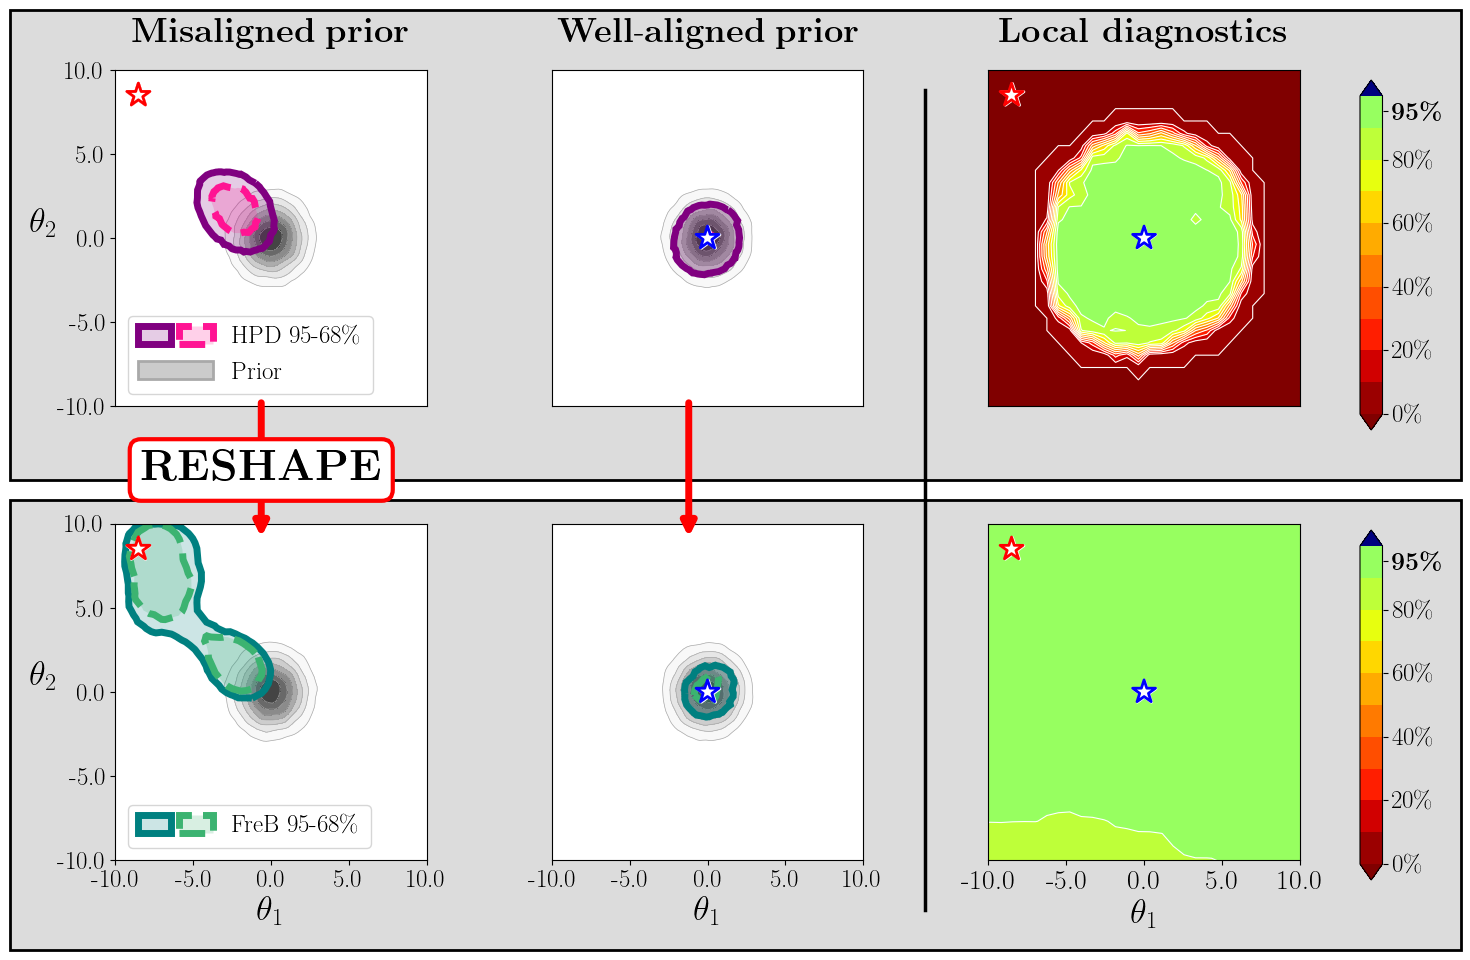

In [6]:
# experiment_dir = 'results/snpe/uniform_prior'
main_dir = f'results/concept_shift/gaussian_reference/posterior_fmpe/p_values_mnn'
experiment_dir = f'results/concept_shift/gaussian_reference/posterior_fmpe/p_values_mnn/20251114_163627_lr0.0005_bs32_ep150_wd1e-05_gp0.0_dr0.0_2b7dfa41'

with open(f'{experiment_dir}/obs_x_theta.pkl', 'rb') as f:
    examples = dill.load(f)
    true_theta = examples['true_theta']
    obs_x = examples['obs_x']
with open(f'{experiment_dir}/lf2i_strong_prior.pkl', 'rb') as f:
    lf2i = dill.load(f)
with open(f'{experiment_dir}/confidence_sets_strong_prior.pkl', 'rb') as f:
    confidence_sets = dill.load(f)
with open(f'{main_dir}/credible_sets_strong_prior.pkl', 'rb') as f:
    credible_sets = dill.load(f)
with open(f'{experiment_dir}/diagn_confset_strong_prior.pkl', 'rb') as f:
    diagn_objects = dill.load(f)
with open(f'{main_dir}/diagn_cred_strong_prior.pkl', 'rb') as f:
    diagn_objects_cred = dill.load(f)

idx_1 = 1
idx_2 = -1

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.gridspec import GridSpec
import numpy as np

fig = plt.figure(figsize=(15, 10))
gs = GridSpec(2, 3, figure=fig, left=0.09, top=0.91, bottom=0.12, right=0.88, hspace=0.35, wspace=0.4)

# Create axes from gridspec
axs = [[fig.add_subplot(gs[i, j]) for j in range(3)] for i in range(2)]

# Add gainsboro patches behind each row (non-overlapping)
# Top row patch
fig.patches.append(patches.Rectangle(
    (0.02, 0.5), 0.967, 0.47, 
    transform=fig.transFigure, 
    edgecolor='black', 
    linewidth=2, 
    facecolor="gainsboro", 
    zorder=-1
))

# Bottom row patch
fig.patches.append(patches.Rectangle(
    (0.02, 0.03), 0.967, 0.45, 
    transform=fig.transFigure, 
    edgecolor='black', 
    linewidth=2, 
    facecolor="gainsboro", 
    zorder=-1
))

idx_obs = idx_1
plot_parameter_regions(
    *[credible_sets[idx_obs][j] for j in range(len(CONFIDENCE_LEVEL))],
    param_dim=2,
    # true_parameter=params_for_size[idx_obs, :],
    true_parameter = true_theta[idx_obs, :],
    prior_samples=PRIOR.sample(sample_shape=(50_000, )).numpy(),
    parameter_space_bounds={
        r'$\theta_1$': dict(zip(['low', 'high'], POI_BOUNDS[r'$\theta_1$'])), 
        r'$\theta_2$': dict(zip(['low', 'high'], POI_BOUNDS[r'$\theta_2$'])), 
    },
    colors=[
        'purple', 'deeppink',
    ],
    region_names=[
        *[f'HPD {int(cl*100):.0f}\%' for cl in CONFIDENCE_LEVEL],
    ],
    labels=[r'$\theta_1$', r'$\theta_2$'],
    linestyles=['-', '--'],
    param_names=[r'$\theta_1$', r'$\theta_2$'],
    alpha_shape=True,
    alpha=3,
    scatter=False,
    remove_legend=False,
    title=r'$\mathbf{Misaligned\ prior}$',
    custom_ax=axs[0][0]
)

plot_parameter_regions(
    *[confidence_sets[j][idx_obs] for j in range(len(CONFIDENCE_LEVEL))],
    param_dim=2,
    # true_parameter=params_for_size[idx_obs, :],
    true_parameter = true_theta[idx_obs, :],
    prior_samples=PRIOR.sample(sample_shape=(50_000, )).numpy(),
    parameter_space_bounds={
        r'$\theta_1$': dict(zip(['low', 'high'], POI_BOUNDS[r'$\theta_1$'])), 
        r'$\theta_2$': dict(zip(['low', 'high'], POI_BOUNDS[r'$\theta_2$'])), 
    },
    colors=[
        'teal', 'mediumseagreen',
    ],
    region_names=[
        *[f'FreB {int(cl*100):.0f}\%' for cl in CONFIDENCE_LEVEL],
    ],
    labels=[r'$\theta_1$', r'$\theta_2$'],
    linestyles=['-', '--'],
    param_names=[r'$\theta_1$', r'$\theta_2$'],
    alpha_shape=True,
    alpha=1,
    scatter=False,
    remove_legend=False,
    title=None,
    custom_ax=axs[1][0]
)

idx_obs = idx_2
# true_parameter=params_for_size[idx_obs, :]
true_parameter = true_theta[idx_obs, :]
plot_parameter_regions(
    *[credible_sets[idx_obs][j] for j in range(len(CONFIDENCE_LEVEL))],
    param_dim=2,
    prior_samples=PRIOR.sample(sample_shape=(50_000, )).numpy(),
    parameter_space_bounds={
        r'$\theta_1$': dict(zip(['low', 'high'], POI_BOUNDS[r'$\theta_1$'])), 
        r'$\theta_2$': dict(zip(['low', 'high'], POI_BOUNDS[r'$\theta_2$'])), 
    },
    colors=[
        'purple', 'deeppink',
    ],
    region_names=[
        *[f'FreB {int(cl*100):.0f}\%' for cl in CONFIDENCE_LEVEL],
    ],
    labels=[r'$\theta_1$', r'$\theta_2$'],
    linestyles=['-', '--'],
    param_names=[r'$\theta_1$', r'$\theta_2$'],
    alpha_shape=True,
    alpha=3,
    scatter=False,
    remove_legend=True,
    title=r'$\mathbf{Well\text{-}aligned\ prior}$',
    custom_ax=axs[0][1]
)
axs[0][1].scatter(x=true_parameter.reshape(-1,)[0], y=true_parameter.reshape(-1,)[1],
    alpha=1, marker='*', facecolor='white', edgecolor='white', s=300, linewidth=2, zorder=10)
axs[0][1].scatter(x=true_parameter.reshape(-1,)[0], y=true_parameter.reshape(-1,)[1],
    alpha=1, marker='*', facecolor='none', edgecolor='blue', s=300, linewidth=2, zorder=10)

plot_parameter_regions(
    *[confidence_sets[j][idx_obs] for j in range(len(CONFIDENCE_LEVEL))],
    param_dim=2,
    prior_samples=PRIOR.sample(sample_shape=(50_000, )).numpy(),
    parameter_space_bounds={
        r'$\theta_1$': dict(zip(['low', 'high'], POI_BOUNDS[r'$\theta_1$'])), 
        r'$\theta_2$': dict(zip(['low', 'high'], POI_BOUNDS[r'$\theta_2$'])), 
    },
    colors=[
        'teal', 'mediumseagreen',
    ],
    region_names=[
        *[f'FreB {int(cl*100):.0f}\%' for cl in CONFIDENCE_LEVEL],
    ],
    labels=[r'$\theta_1$', r'$\theta_2$'],
    linestyles=['-', '--'],
    param_names=[r'$\theta_1$', r'$\theta_2$'],
    alpha_shape=True,
    alpha=3,
    scatter=False,
    # alpha_shape=False,
    # alpha=6,
    # scatter=True,
    remove_legend=True,
    title=None,
    custom_ax=axs[1][1]
)
axs[1][1].scatter(x=true_parameter.reshape(-1,)[0], y=true_parameter.reshape(-1,)[1],
    alpha=1, marker='*', facecolor='white', edgecolor='white', s=300, linewidth=2, zorder=10)
axs[1][1].scatter(x=true_parameter.reshape(-1,)[0], y=true_parameter.reshape(-1,)[1],
    alpha=1, marker='*', facecolor='none', edgecolor='blue', s=300, linewidth=2, zorder=10)

## Local diagnostics
hpd_diagn_plot = coverage_probability_plot(
    parameters=diagn_objects_cred[CONFIDENCE_LEVEL[0]][1],
    coverage_probability=diagn_objects_cred[CONFIDENCE_LEVEL[0]][2],
    confidence_level=CONFIDENCE_LEVEL[0],
    param_dim=2,
    vmin_vmax=(0, 100),
    xlims=(-10, 10),
    ylims=(-10, 10),
    params_labels=(r'$\theta_1$', r'$\theta_2$'),
    #figsize=(9, 7),
    title=r'\textbf{Local diagnostics}',
    show_text=False,
    custom_ax=axs[0][2],
    # n_bins=8,
    n_levels=11,
)

idx_obs = idx_1
# true_parameter=params_for_size[idx_obs, :]
true_parameter = true_theta[idx_obs, :]
axs[0][2].scatter(x=true_parameter.reshape(-1,)[0], y=true_parameter.reshape(-1,)[1],
    alpha=1, marker='*', facecolor='white', edgecolor='white', s=300, linewidth=2, zorder=10)
axs[0][2].scatter(x=true_parameter.reshape(-1,)[0], y=true_parameter.reshape(-1,)[1],
    alpha=1, marker='*', facecolor='none', edgecolor='red', s=300, linewidth=2, zorder=10)

idx_obs = idx_2
# true_parameter=params_for_size[idx_obs, :]
true_parameter = true_theta[idx_obs, :]
axs[0][2].scatter(x=true_parameter.reshape(-1,)[0], y=true_parameter.reshape(-1,)[1],
    alpha=1, marker='*', facecolor='white', edgecolor='white', s=300, linewidth=2, zorder=10)
axs[0][2].scatter(x=true_parameter.reshape(-1,)[0], y=true_parameter.reshape(-1,)[1],
    alpha=1, marker='*', facecolor='none', edgecolor='blue', s=300, linewidth=2, zorder=10)

freb_diagn_plot = coverage_probability_plot(
    parameters=diagn_objects[CONFIDENCE_LEVEL[0]][1],
    coverage_probability=diagn_objects[CONFIDENCE_LEVEL[0]][2],
    confidence_level=CONFIDENCE_LEVEL[0],
    param_dim=2,
    vmin_vmax=(0, 100),
    params_labels=(r'$\theta_1$', r'$\theta_2$'),
    xlims=(-10, 10),
    ylims=(-10, 10),
    #figsize=(9, 7),
    title=None,
    show_text=False,
    custom_ax=axs[1][2],
    # n_bins=8,
    n_levels=11
)

idx_obs = idx_1
# true_parameter=params_for_size[idx_obs, :]
true_parameter = true_theta[idx_obs, :]
axs[1][2].scatter(x=true_parameter.reshape(-1,)[0], y=true_parameter.reshape(-1,)[1],
    alpha=1, marker='*', facecolor='white', edgecolor='white', s=300, linewidth=2, zorder=10)
axs[1][2].scatter(x=true_parameter.reshape(-1,)[0], y=true_parameter.reshape(-1,)[1],
    alpha=1, marker='*', facecolor='none', edgecolor='red', s=300, linewidth=2, zorder=10)

idx_obs = idx_2
# true_parameter=params_for_size[idx_obs, :]
true_parameter = true_theta[idx_obs, :]
axs[1][2].scatter(x=true_parameter.reshape(-1,)[0], y=true_parameter.reshape(-1,)[1],
    alpha=1, marker='*', facecolor='white', edgecolor='white', s=300, linewidth=2, zorder=10)
axs[1][2].scatter(x=true_parameter.reshape(-1,)[0], y=true_parameter.reshape(-1,)[1],
    alpha=1, marker='*', facecolor='none', edgecolor='blue', s=300, linewidth=2, zorder=10)

#  Add colorbar for top row (rightmost column)
cax_top = fig.add_axes([0.92, 0.55, 0.015, 0.35])
cbar_top = fig.colorbar(hpd_diagn_plot, cax=cax_top)
standard_ticks = np.round(np.linspace(0, 100, num=6), 1)
all_ticks = np.unique(np.sort(np.append(standard_ticks[:-1], CONFIDENCE_LEVEL[0] * 100)))
tick_labels = [f"{label:.0f}\%" for label in all_ticks]
for i, label in enumerate(all_ticks):
    if abs(label - CONFIDENCE_LEVEL[0]*100) <= 1e-6:
        tick_labels[i] = r"$\mathbf{{{label}}}$\textbf{{\%}}".format(label=int(label))
cbar_top.ax.yaxis.set_ticks(all_ticks)
cbar_top.ax.set_yticklabels(tick_labels, fontsize=18)
cbar_top.ax.yaxis.set_ticks_position('right')
cbar_top.ax.yaxis.set_label_position('right')
# cbar_top.set_label('Percentage of $\\text{Vol}(\Theta)$', rotation=270, labelpad=20, fontsize=18)

# Add colorbar for bottom row (rightmost column)
cax_bottom = fig.add_axes([0.92, 0.10, 0.015, 0.35])
cbar_bottom = fig.colorbar(freb_diagn_plot, cax=cax_bottom)
cbar_bottom.ax.yaxis.set_ticks(all_ticks)
cbar_bottom.ax.set_yticklabels(tick_labels, fontsize=18)
cbar_bottom.ax.yaxis.set_ticks_position('right')
cbar_bottom.ax.yaxis.set_label_position('right')
# cbar_bottom.set_label('Percentage of $\\text{Vol}(\Theta)$', rotation=270, labelpad=20, fontsize=18)

line = mlines.Line2D(
    [0.63, 0.63],   # x-coords (start, end)
    [0.07, 0.89],               # y-coords (start, end)
    transform=fig.transFigure,
    ls='-',                  # dashed
    lw=2.5,
    color='black',
    clip_on=False
)

fig.add_artist(line)

fig.add_artist(FancyArrowPatch(
    posA=(0.1875, 0.58), posB=(0.1875, 0.44),
    connectionstyle="arc3,rad=0", arrowstyle='-|>', mutation_scale=20, 
    color='red', linewidth=5, zorder=10
))
fig.text(0.1875, 0.51, r"{\bf RESHAPE}", fontsize=32, color='black', ha='center', va='center', bbox=dict(facecolor='white', edgecolor='red', boxstyle='round,pad=0.25', linewidth=3), zorder=21)

fig.add_artist(FancyArrowPatch(
    posA=(0.4725, 0.58), posB=(0.4725, 0.44),
    connectionstyle="arc3,rad=0", arrowstyle='-|>', mutation_scale=20, 
    color='red', linewidth=5, zorder=10
))

axs[0][0].set_xlabel('')
axs[0][0].set_xticks([])

axs[0][1].set_xlabel('')
axs[0][1].set_xticks([])
axs[0][1].set_ylabel('')
axs[0][1].set_yticks([])

axs[0][2].set_xlabel('')
axs[0][2].set_xticks([])
axs[0][2].set_ylabel('')
axs[0][2].set_yticks([])

axs[1][1].set_ylabel('')
axs[1][1].set_yticks([])

axs[1][2].set_ylabel('')
axs[1][2].set_yticks([])

plt.savefig(f'{experiment_dir}/gmm_misspecified_reresolved.png', dpi=100)
plt.savefig(f'{experiment_dir}/gmm_misspecified_reresolved.pdf', dpi=100)
plt.show()

/home/jcarzon/research/tsi/lf2i/src/lf2i/plot/parameter_regions.py:373: UserWarning: Contour might be unreliable if alpha is not chosen properly. Please plot scatter as well, and choose alpha appropriately (try from 1 to 20).
  warnings.warn("Contour might be unreliable if alpha is not chosen properly. Please plot scatter as well, and choose alpha appropriately (try from 1 to 20).")
/home/jcarzon/research/tsi/lf2i/src/lf2i/plot/parameter_regions.py:373: UserWarning: Contour might be unreliable if alpha is not chosen properly. Please plot scatter as well, and choose alpha appropriately (try from 1 to 20).
  warnings.warn("Contour might be unreliable if alpha is not chosen properly. Please plot scatter as well, and choose alpha appropriately (try from 1 to 20).")
/home/jcarzon/research/tsi/lf2i/src/lf2i/plot/parameter_regions.py:373: UserWarning: Contour might be unreliable if alpha is not chosen properly. Please plot scatter as well, and choose alpha appropriately (try from 1 to 20).
  

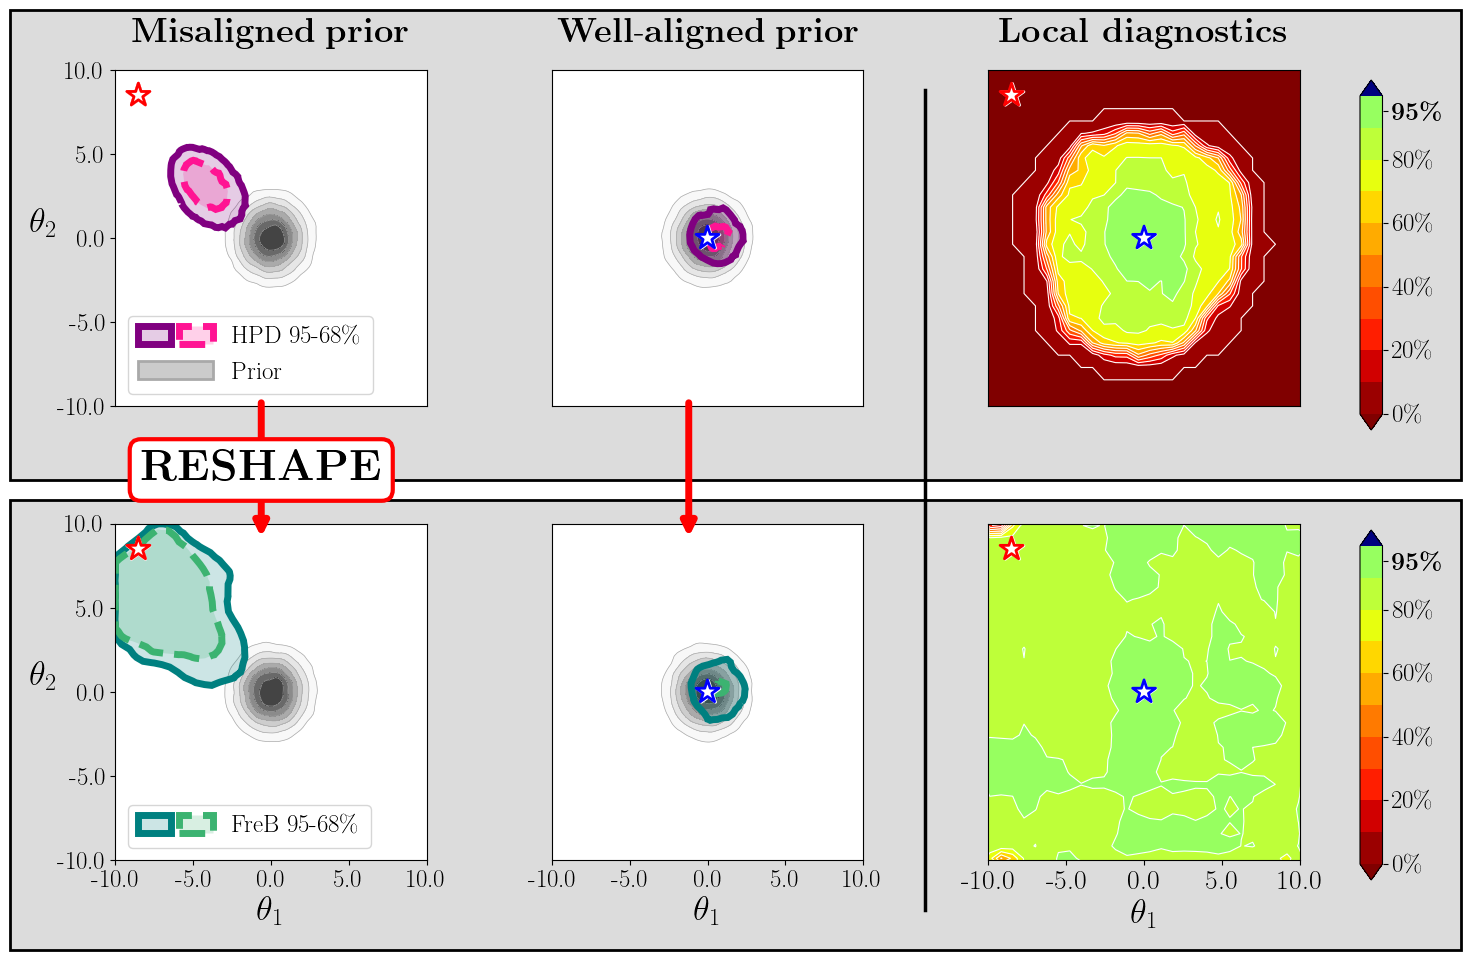

In [9]:
# experiment_dir = 'results/snpe/uniform_prior'
main_dir = f'results/no_shift/uniform_reference/posterior_fmpe/p_values_mnn'
experiment_dir = f'results/no_shift/uniform_reference/posterior_fmpe/p_values_mnn/20251120_012955_lr0.0005_bs32_ep150_wd1e-05_gp0.0_dr0.0_2b7dfa41'

with open(f'{experiment_dir}/obs_x_theta.pkl', 'rb') as f:
    examples = dill.load(f)
    true_theta = examples['true_theta']
    obs_x = examples['obs_x']
with open(f'{experiment_dir}/lf2i_strong_prior.pkl', 'rb') as f:
    lf2i = dill.load(f)
with open(f'{experiment_dir}/confidence_sets_strong_prior.pkl', 'rb') as f:
    confidence_sets = dill.load(f)
with open(f'{main_dir}/credible_sets_strong_prior.pkl', 'rb') as f:
    credible_sets = dill.load(f)
with open(f'{experiment_dir}/diagn_confset_strong_prior.pkl', 'rb') as f:
    diagn_objects = dill.load(f)
with open(f'{main_dir}/diagn_cred_strong_prior.pkl', 'rb') as f:
    diagn_objects_cred = dill.load(f)

idx_1 = 1
idx_2 = 9

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.gridspec import GridSpec
import numpy as np

fig = plt.figure(figsize=(15, 10))
gs = GridSpec(2, 3, figure=fig, left=0.09, top=0.91, bottom=0.12, right=0.88, hspace=0.35, wspace=0.4)

# Create axes from gridspec
axs = [[fig.add_subplot(gs[i, j]) for j in range(3)] for i in range(2)]

# Add gainsboro patches behind each row (non-overlapping)
# Top row patch
fig.patches.append(patches.Rectangle(
    (0.02, 0.5), 0.967, 0.47, 
    transform=fig.transFigure, 
    edgecolor='black', 
    linewidth=2, 
    facecolor="gainsboro", 
    zorder=-1
))

# Bottom row patch
fig.patches.append(patches.Rectangle(
    (0.02, 0.03), 0.967, 0.45, 
    transform=fig.transFigure, 
    edgecolor='black', 
    linewidth=2, 
    facecolor="gainsboro", 
    zorder=-1
))

idx_obs = idx_1
plot_parameter_regions(
    *[credible_sets[idx_obs][j] for j in range(len(CONFIDENCE_LEVEL))],
    param_dim=2,
    # true_parameter=params_for_size[idx_obs, :],
    true_parameter = true_theta[idx_obs, :],
    prior_samples=PRIOR.sample(sample_shape=(50_000, )).numpy(),
    parameter_space_bounds={
        r'$\theta_1$': dict(zip(['low', 'high'], POI_BOUNDS[r'$\theta_1$'])), 
        r'$\theta_2$': dict(zip(['low', 'high'], POI_BOUNDS[r'$\theta_2$'])), 
    },
    colors=[
        'purple', 'deeppink',
    ],
    region_names=[
        *[f'HPD {int(cl*100):.0f}\%' for cl in CONFIDENCE_LEVEL],
    ],
    labels=[r'$\theta_1$', r'$\theta_2$'],
    linestyles=['-', '--'],
    param_names=[r'$\theta_1$', r'$\theta_2$'],
    alpha_shape=True,
    alpha=3,
    scatter=False,
    remove_legend=False,
    title=r'$\mathbf{Misaligned\ prior}$',
    custom_ax=axs[0][0]
)

plot_parameter_regions(
    *[confidence_sets[j][idx_obs] for j in range(len(CONFIDENCE_LEVEL))],
    param_dim=2,
    # true_parameter=params_for_size[idx_obs, :],
    true_parameter = true_theta[idx_obs, :],
    prior_samples=PRIOR.sample(sample_shape=(50_000, )).numpy(),
    parameter_space_bounds={
        r'$\theta_1$': dict(zip(['low', 'high'], POI_BOUNDS[r'$\theta_1$'])), 
        r'$\theta_2$': dict(zip(['low', 'high'], POI_BOUNDS[r'$\theta_2$'])), 
    },
    colors=[
        'teal', 'mediumseagreen',
    ],
    region_names=[
        *[f'FreB {int(cl*100):.0f}\%' for cl in CONFIDENCE_LEVEL],
    ],
    labels=[r'$\theta_1$', r'$\theta_2$'],
    linestyles=['-', '--'],
    param_names=[r'$\theta_1$', r'$\theta_2$'],
    alpha_shape=True,
    alpha=1,
    scatter=False,
    remove_legend=False,
    title=None,
    custom_ax=axs[1][0]
)

idx_obs = idx_2
# true_parameter=params_for_size[idx_obs, :]
true_parameter = true_theta[idx_obs, :]
plot_parameter_regions(
    *[credible_sets[idx_obs][j] for j in range(len(CONFIDENCE_LEVEL))],
    param_dim=2,
    prior_samples=PRIOR.sample(sample_shape=(50_000, )).numpy(),
    parameter_space_bounds={
        r'$\theta_1$': dict(zip(['low', 'high'], POI_BOUNDS[r'$\theta_1$'])), 
        r'$\theta_2$': dict(zip(['low', 'high'], POI_BOUNDS[r'$\theta_2$'])), 
    },
    colors=[
        'purple', 'deeppink',
    ],
    region_names=[
        *[f'FreB {int(cl*100):.0f}\%' for cl in CONFIDENCE_LEVEL],
    ],
    labels=[r'$\theta_1$', r'$\theta_2$'],
    linestyles=['-', '--'],
    param_names=[r'$\theta_1$', r'$\theta_2$'],
    alpha_shape=True,
    alpha=3,
    scatter=False,
    remove_legend=True,
    title=r'$\mathbf{Well\text{-}aligned\ prior}$',
    custom_ax=axs[0][1]
)
axs[0][1].scatter(x=true_parameter.reshape(-1,)[0], y=true_parameter.reshape(-1,)[1],
    alpha=1, marker='*', facecolor='white', edgecolor='white', s=300, linewidth=2, zorder=10)
axs[0][1].scatter(x=true_parameter.reshape(-1,)[0], y=true_parameter.reshape(-1,)[1],
    alpha=1, marker='*', facecolor='none', edgecolor='blue', s=300, linewidth=2, zorder=10)

plot_parameter_regions(
    *[confidence_sets[j][idx_obs] for j in range(len(CONFIDENCE_LEVEL))],
    param_dim=2,
    prior_samples=PRIOR.sample(sample_shape=(50_000, )).numpy(),
    parameter_space_bounds={
        r'$\theta_1$': dict(zip(['low', 'high'], POI_BOUNDS[r'$\theta_1$'])), 
        r'$\theta_2$': dict(zip(['low', 'high'], POI_BOUNDS[r'$\theta_2$'])), 
    },
    colors=[
        'teal', 'mediumseagreen',
    ],
    region_names=[
        *[f'FreB {int(cl*100):.0f}\%' for cl in CONFIDENCE_LEVEL],
    ],
    labels=[r'$\theta_1$', r'$\theta_2$'],
    linestyles=['-', '--'],
    param_names=[r'$\theta_1$', r'$\theta_2$'],
    alpha_shape=True,
    alpha=3,
    scatter=False,
    # alpha_shape=False,
    # alpha=6,
    # scatter=True,
    remove_legend=True,
    title=None,
    custom_ax=axs[1][1]
)
axs[1][1].scatter(x=true_parameter.reshape(-1,)[0], y=true_parameter.reshape(-1,)[1],
    alpha=1, marker='*', facecolor='white', edgecolor='white', s=300, linewidth=2, zorder=10)
axs[1][1].scatter(x=true_parameter.reshape(-1,)[0], y=true_parameter.reshape(-1,)[1],
    alpha=1, marker='*', facecolor='none', edgecolor='blue', s=300, linewidth=2, zorder=10)

## Local diagnostics
hpd_diagn_plot = coverage_probability_plot(
    parameters=diagn_objects_cred[CONFIDENCE_LEVEL[0]][1],
    coverage_probability=diagn_objects_cred[CONFIDENCE_LEVEL[0]][2],
    confidence_level=CONFIDENCE_LEVEL[0],
    param_dim=2,
    vmin_vmax=(0, 100),
    xlims=(-10, 10),
    ylims=(-10, 10),
    params_labels=(r'$\theta_1$', r'$\theta_2$'),
    #figsize=(9, 7),
    title=r'\textbf{Local diagnostics}',
    show_text=False,
    custom_ax=axs[0][2],
    # n_bins=8,
    n_levels=11,
)

idx_obs = idx_1
# true_parameter=params_for_size[idx_obs, :]
true_parameter = true_theta[idx_obs, :]
axs[0][2].scatter(x=true_parameter.reshape(-1,)[0], y=true_parameter.reshape(-1,)[1],
    alpha=1, marker='*', facecolor='white', edgecolor='white', s=300, linewidth=2, zorder=10)
axs[0][2].scatter(x=true_parameter.reshape(-1,)[0], y=true_parameter.reshape(-1,)[1],
    alpha=1, marker='*', facecolor='none', edgecolor='red', s=300, linewidth=2, zorder=10)

idx_obs = idx_2
# true_parameter=params_for_size[idx_obs, :]
true_parameter = true_theta[idx_obs, :]
axs[0][2].scatter(x=true_parameter.reshape(-1,)[0], y=true_parameter.reshape(-1,)[1],
    alpha=1, marker='*', facecolor='white', edgecolor='white', s=300, linewidth=2, zorder=10)
axs[0][2].scatter(x=true_parameter.reshape(-1,)[0], y=true_parameter.reshape(-1,)[1],
    alpha=1, marker='*', facecolor='none', edgecolor='blue', s=300, linewidth=2, zorder=10)

freb_diagn_plot = coverage_probability_plot(
    parameters=diagn_objects[CONFIDENCE_LEVEL[0]][1],
    coverage_probability=diagn_objects[CONFIDENCE_LEVEL[0]][2],
    confidence_level=CONFIDENCE_LEVEL[0],
    param_dim=2,
    vmin_vmax=(0, 100),
    params_labels=(r'$\theta_1$', r'$\theta_2$'),
    xlims=(-10, 10),
    ylims=(-10, 10),
    #figsize=(9, 7),
    title=None,
    show_text=False,
    custom_ax=axs[1][2],
    # n_bins=8,
    n_levels=11
)

idx_obs = idx_1
# true_parameter=params_for_size[idx_obs, :]
true_parameter = true_theta[idx_obs, :]
axs[1][2].scatter(x=true_parameter.reshape(-1,)[0], y=true_parameter.reshape(-1,)[1],
    alpha=1, marker='*', facecolor='white', edgecolor='white', s=300, linewidth=2, zorder=10)
axs[1][2].scatter(x=true_parameter.reshape(-1,)[0], y=true_parameter.reshape(-1,)[1],
    alpha=1, marker='*', facecolor='none', edgecolor='red', s=300, linewidth=2, zorder=10)

idx_obs = idx_2
# true_parameter=params_for_size[idx_obs, :]
true_parameter = true_theta[idx_obs, :]
axs[1][2].scatter(x=true_parameter.reshape(-1,)[0], y=true_parameter.reshape(-1,)[1],
    alpha=1, marker='*', facecolor='white', edgecolor='white', s=300, linewidth=2, zorder=10)
axs[1][2].scatter(x=true_parameter.reshape(-1,)[0], y=true_parameter.reshape(-1,)[1],
    alpha=1, marker='*', facecolor='none', edgecolor='blue', s=300, linewidth=2, zorder=10)

#  Add colorbar for top row (rightmost column)
cax_top = fig.add_axes([0.92, 0.55, 0.015, 0.35])
cbar_top = fig.colorbar(hpd_diagn_plot, cax=cax_top)
standard_ticks = np.round(np.linspace(0, 100, num=6), 1)
all_ticks = np.unique(np.sort(np.append(standard_ticks[:-1], CONFIDENCE_LEVEL[0] * 100)))
tick_labels = [f"{label:.0f}\%" for label in all_ticks]
for i, label in enumerate(all_ticks):
    if abs(label - CONFIDENCE_LEVEL[0]*100) <= 1e-6:
        tick_labels[i] = r"$\mathbf{{{label}}}$\textbf{{\%}}".format(label=int(label))
cbar_top.ax.yaxis.set_ticks(all_ticks)
cbar_top.ax.set_yticklabels(tick_labels, fontsize=18)
cbar_top.ax.yaxis.set_ticks_position('right')
cbar_top.ax.yaxis.set_label_position('right')
# cbar_top.set_label('Percentage of $\\text{Vol}(\Theta)$', rotation=270, labelpad=20, fontsize=18)

# Add colorbar for bottom row (rightmost column)
cax_bottom = fig.add_axes([0.92, 0.10, 0.015, 0.35])
cbar_bottom = fig.colorbar(freb_diagn_plot, cax=cax_bottom)
cbar_bottom.ax.yaxis.set_ticks(all_ticks)
cbar_bottom.ax.set_yticklabels(tick_labels, fontsize=18)
cbar_bottom.ax.yaxis.set_ticks_position('right')
cbar_bottom.ax.yaxis.set_label_position('right')
# cbar_bottom.set_label('Percentage of $\\text{Vol}(\Theta)$', rotation=270, labelpad=20, fontsize=18)

line = mlines.Line2D(
    [0.63, 0.63],   # x-coords (start, end)
    [0.07, 0.89],               # y-coords (start, end)
    transform=fig.transFigure,
    ls='-',                  # dashed
    lw=2.5,
    color='black',
    clip_on=False
)

fig.add_artist(line)

fig.add_artist(FancyArrowPatch(
    posA=(0.1875, 0.58), posB=(0.1875, 0.44),
    connectionstyle="arc3,rad=0", arrowstyle='-|>', mutation_scale=20, 
    color='red', linewidth=5, zorder=10
))
fig.text(0.1875, 0.51, r"{\bf RESHAPE}", fontsize=32, color='black', ha='center', va='center', bbox=dict(facecolor='white', edgecolor='red', boxstyle='round,pad=0.25', linewidth=3), zorder=21)

fig.add_artist(FancyArrowPatch(
    posA=(0.4725, 0.58), posB=(0.4725, 0.44),
    connectionstyle="arc3,rad=0", arrowstyle='-|>', mutation_scale=20, 
    color='red', linewidth=5, zorder=10
))

axs[0][0].set_xlabel('')
axs[0][0].set_xticks([])

axs[0][1].set_xlabel('')
axs[0][1].set_xticks([])
axs[0][1].set_ylabel('')
axs[0][1].set_yticks([])

axs[0][2].set_xlabel('')
axs[0][2].set_xticks([])
axs[0][2].set_ylabel('')
axs[0][2].set_yticks([])

axs[1][1].set_ylabel('')
axs[1][1].set_yticks([])

axs[1][2].set_ylabel('')
axs[1][2].set_yticks([])

plt.savefig(f'{experiment_dir}/gmm_well_specified_reresolved.png', dpi=100)
plt.savefig(f'{experiment_dir}/gmm_well_specified_reresolved.pdf', dpi=100)
plt.show()